### Deep Q-learning for multi-armed bandits 

This notebook runs a "multi-armed bandit" problem using the DQN framework. This is definitely using a hammer for a nail, but it illustrates the approach to more complex deep Q-learning problems. 

For multi-armed bandits, the 
optimal strategy is to always pull the arm with the largest expected reward, as soon 
as you know that's the best arm.

This notebook also serves as a working example for automatic differentiation in tensorflow.

Adapted from [this post](https://towardsdatascience.com/a-minimal-working-example-for-deep-q-learning-in-tensorflow-2-0-e0ca8a944d5e).


In [1]:
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
def get_reward(bandit: float):
    """Generate reward for selected bandit"""
    reward = tf.random.normal([1], mean=bandit, stddev=1, dtype=tf.dtypes.float32)
    return reward


def construct_q_network(state_dim: int, action_dim: int):
    """Construct the Q-network with q-values per action as output"""
    inputs = layers.Input(shape=(state_dim,))  # input dimension
    hidden1 = layers.Dense(10, activation="relu")(inputs)
    hidden2 = layers.Dense(10, activation="relu")(hidden1)
    hidden3 = layers.Dense(10, activation="relu")(hidden2)
    q_values = layers.Dense(action_dim, activation="linear")(hidden3)
    deep_q_network = keras.Model(inputs=inputs, outputs=[q_values])
    return deep_q_network


def mean_squared_error_loss(q_value: tf.Tensor, reward: tf.Tensor):
    """Compute mean squared error loss"""
    loss = 0.5 * (q_value - reward) ** 2
    return loss

def plot(q_values: tf.Tensor, bandits: np.array):
    """Plot bar chart with selection probability per bandit"""
    q_values_plot = [q_values[i] for i in range(len(q_values))]
    bandit_plot = [bandits[i] for i in range(len(bandits))]
    width = 0.4
    x = np.arange(len(bandits))
    
    plt.figure(figsize=(12,7))
    fig, ax = plt.subplots()
    ax.bar(x - width / 2, q_values_plot, width, label="Q-values")
    ax.bar(x + width / 2, bandit_plot, width, label="True values")

    ax.set_xticks(range(len(q_values)))
    plt.xlabel("Bandit")
    plt.ylabel("Value")
    plt.legend(loc="best")
    plt.show()
    return



======episode 10000 ======
Q-values ['0.871', '1.154', '0.609', '1.278', '1.426']
Deviation ['-3.3%', '-3.8%', '-13.1%', '27.8%', '-5.0%']


<Figure size 864x504 with 0 Axes>

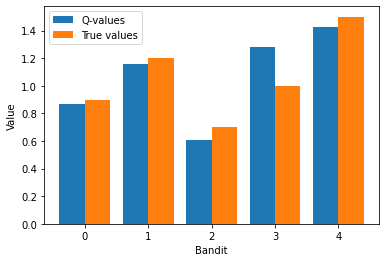

In [3]:
# Initialize parameters
state = tf.constant([[1]])
bandits = np.array([0.9, 1.2, 0.7, 1.0, 1.5])
state_dim = len(state)
action_dim = len(bandits)
exploration_rate = 0.01
learning_rate = 0.01
num_episodes = 10000

# Construct Q-network
q_network = construct_q_network(state_dim, action_dim)

# Define optimizer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

for i in range(num_episodes + 1):
    with tf.GradientTape() as tape:
        # Obtain Q-values from network
        q_values = q_network(state)

        epsilon = np.random.rand()
        if epsilon <= exploration_rate:
            # Select random action
            action = np.random.choice(len(bandits))
        else:
            # Select action with highest q-value
            action = np.argmax(q_values)
            
        # Obtain reward from bandit
        reward = get_reward(bandits[action])

        # Obtain Q-value
        q_value = q_values[0, action]

        # Compute loss value
        loss_value = mean_squared_error_loss(q_value, reward)

        # Compute gradients
        grads = tape.gradient(loss_value[0], q_network.trainable_variables)

        # Apply gradients to update network weights
        opt.apply_gradients(zip(grads, q_network.trainable_variables))
        
        # Print console output
        if np.mod(i, 500) == 0:
            clear_output(wait=True)
            print("\n======episode", i, "======")
            print("Q-values", ["%.3f" % n for n in q_values[0]])
            print("Deviation",
                ["%.1f%%" % float(100*(q_values[0, i] - bandits[i]) / bandits[i]) for i in range(len(q_values[0]))])
            plot(q_values[0], bandits)
            
